# PART 1 - Loading & Pre Processing 

### Platforms: Shell Scripting, Python 3

#### Steps:
*All of this can be automated using wget command, but due to NDA, the data cannot be put on public Github repository and as such cannot utilize wget. 
     1. Visit www.datanotebook.org (Password: simplex)
     2. On the upper right corner, select 'Upload' to upload 'Problem-2.ipynb' + all accompanying csv files.
     3. Double click on Problem-2.ipynb to start notebook
     4. On the toggle bar, select Run > Run All
     
     * Load some python visualization libraries 
     * Run 'csvstat' - to get descriptive stats of each file + observe any missing or NULL values
    

In [1]:
from bokeh.plotting import figure, show, output_file
from bokeh.io import push_notebook, show, output_notebook
from bokeh.plotting import figure
from bokeh.charts import Bar
output_notebook()

Loading BokehJS ...

In [2]:
!csvstat dim_acct.csv

  1. ACCT_ID
	<class 'int'>
	Nulls: False
	Min: 112110616977376
	Max: 4611679791824819900
	Sum: 22730670545637110906347
	Mean: 2.2953317727594778e+18
	Median: 2316664370354537529
	Standard Deviation: 1.333126148041693e+18
	Unique values: 9903
  2. COUNTRY_CODE
	<class 'str'>
	Nulls: False
	Unique values: 11
	5 most frequent values:
		US:	8010
		CA:	1254
		BR:	335
		MX:	131
		AR:	87
	Max length: 2
  3. LANGUAGE_CODE
	<class 'str'>
	Nulls: False
	Values: es, fr, en, pt
  4. OPT_IN_FLAG
	<class 'int'>
	Nulls: False
	Values: 0, 1

Row count: 9903


In [3]:
!csvstat dim_product.csv

  1. sku
	<class 'int'>
	Nulls: False
	Min: 24996
	Max: 76813
	Sum: 47339896
	Mean: 63886.49932523617
	Median: 63589
	Standard Deviation: 8827.863736954238
	Unique values: 709
	5 most frequent values:
		73404:	3
		56032:	2
		59574:	2
		73827:	2
		73690:	2
  2. game_name
	<class 'str'>
	Nulls: False
	Values: Fifa 15, Fifa 16, Destiny

Row count: 741


In [4]:
!csvstat fct_transaction.csv

  1. ACCT_ID
	<class 'int'>
	Nulls: False
	Min: 112110616977376
	Max: 4611679791824819900
	Sum: 22832397974228024195145
	Mean: 2.2958670662873833e+18
	Median: 2318601711805822924
	Standard Deviation: 1.3333984314874568e+18
	Unique values: 9903
	5 most frequent values:
		897924179274989253:	2
		3974400860039657607:	2
		3302592783285312504:	2
		2316930479434432568:	2
		603030439962872616:	2
  2. TRANSACTION_TIMESTAMP
	<class 'datetime.datetime'>
	Nulls: False
	Min: 2015-10-18 00:00:00
	Max: 2015-11-16 16:24:00
	Unique values: 8469
	5 most frequent values:
		2015-10-18 00:00:00:	6
		2015-10-18 00:50:00:	4
		2015-11-16 01:30:00:	4
		2015-11-06 01:53:00:	4
		2015-10-29 20:54:00:	4
  3. TRANSACTION_VALUE
	<class 'float'>
	Nulls: False
	Min: 0.36567
	Max: 149.99
	Sum: 189099.6233399983
	Mean: 19.01454231674191
	Median: 9.99
	Standard Deviation: 22.599633708954638
	Unique values: 385
	5 most frequent values:
		9.99:	1122
		1.99:	990
		19.99:	951
		59.99:	742
		4.99:	731
  4. SKU
	<class 'int'>

# PART 2 - Creating Db (using PostgreSQL)

### Platforms: PostgreSQL, Python 3

#### Steps:
    1. Load SQL to Kernel and create a localhost postgresql server
       -Any server can be used (mySQL, sqlite, etc.)
       -I personally prefer PostgreSQL due to its object oriented structure 
    2. Create TABLES and populate with respective csv files
    3. Run sanity check to see if all data has loaded appropriately onto the local server.

In [5]:
%load_ext sql

/opt/conda/lib/python3.5/site-packages/IPython/config.py:13: ShimWarning: The `IPython.config` package has been deprecated. You should import from traitlets.config instead.
  "You should import from traitlets.config instead.", ShimWarning)
/opt/conda/lib/python3.5/site-packages/IPython/utils/traitlets.py:5: UserWarning: IPython.utils.traitlets has moved to a top-level traitlets package.
  warn("IPython.utils.traitlets has moved to a top-level traitlets package.")


In [6]:
!echo 'redspot' | sudo -S service postgresql restart

[sudo] password for jovyan: Restarting PostgreSQL 9.5 database server: main.


In [7]:
!createdb -U dbuser CRM

In [8]:
%sql postgresql://dbuser@localhost:5432/CRM

'Connected: dbuser@CRM'

## 2a. Account TABLE

In [9]:
%%sql
DROP TABLE IF EXISTS account;
CREATE TABLE account (
    ACCT_ID FLOAT,
    COUNTRY_CODE VARCHAR(2),
    LANGUAGE_CODE VARCHAR(2),
    OPT_IN_FLAG INT,
    PRIMARY KEY (ACCT_ID)
    )

Done.
Done.


[]

In [10]:
!pwd

/home/jovyan/work


In [11]:
%%sql
COPY account FROM '/home/jovyan/work/dim_acct.csv'
CSV
HEADER
QUOTE '"'
DELIMITER ',';

9903 rows affected.


[]

In [12]:
%%sql
SELECT count(account.ACCT_ID) FROM account;

1 rows affected.


count
9903


In [13]:
%%sql
SELECT COUNT(DISTINCT(ACCT_ID)) from account

1 rows affected.


count
9903


##### Sanity Check:
##### The DISTINCT query is to check if all account_id's are unique. Since that is the case, we can safely use that as the PRIMARY KEY. 
If such wasn't the case, we would have gotten an error during table initialization also. However, this is a good sanity check

##### Basic data exploration:
Let's see where most of our customers are located, what language they speak and whether they have opted-in to receive marketing offers.

In [14]:
%%sql 
SELECT COUNTRY_CODE as Country, COUNT(COUNTRY_CODE) as Count
FROM account
GROUP BY Country
ORDER BY count DESC;

11 rows affected.


country,count
US,8010
CA,1254
BR,335
MX,131
AR,87
CL,51
CO,14
PE,12
PA,4
EC,3


/opt/conda/lib/python3.5/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
/opt/conda/lib/python3.5/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


Account Distribution by Country


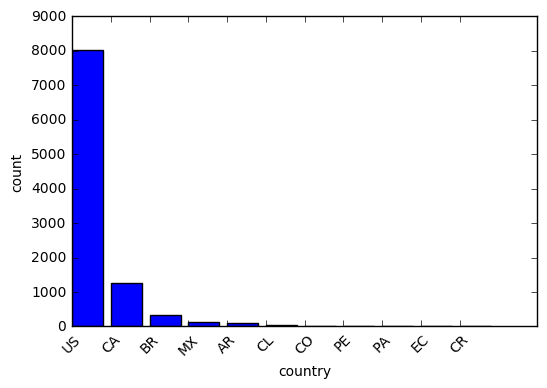

In [15]:
from pandas import DataFrame
import matplotlib
%matplotlib inline 

q1_results = _
q1_results.bar()
!echo 'Account Distribution by Country'

###### So most of our customer base in the US

In [16]:
%%sql 
SELECT LANGUAGE_CODE as Language, COUNT(LANGUAGE_CODE) as Count
FROM account
WHERE COUNTRY_CODE = 'US'
GROUP BY Language
ORDER BY count DESC;

1 rows affected.


language,count
en,8010


###### And NOT surprisingly they all speak English

In [17]:
%%sql 
SELECT OPT_IN_FLAG as OptIn, COUNT(OPT_IN_FLAG) as Count
FROM account
WHERE COUNTRY_CODE = 'US'
AND LANGUAGE_CODE = 'en'
GROUP BY OptIn
ORDER BY count DESC;

2 rows affected.


optin,count
1,4150
0,3860


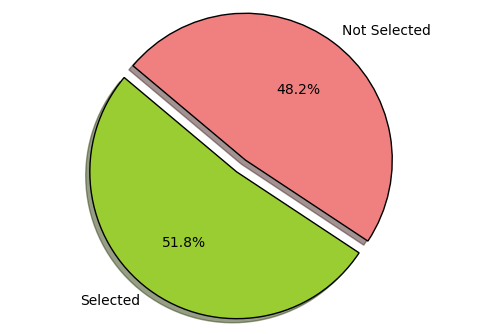

In [18]:
q2= _
df=q2.DataFrame()

import matplotlib.pyplot as plt
 
# Data to plot
labels = 'Selected', 'Not Selected'
sizes = df['count']
colors = ['yellowgreen', 'lightcoral']
explode = (0.1, 0)  # explode 1st slice
 
# Plot
plt.pie(sizes, explode=explode, labels=labels, colors=colors,
        autopct='%1.1f%%', shadow=True, startangle=140)
 
plt.axis('equal')
plt.show()

##### And about half of our customers have chosen the option of 'Opt-in' marketing.*
*Assumption: The sample data in accounts in representative of actual population

In [19]:
%%sql
SELECT COUNT(DISTINCT(ACCT_ID))
FROM account
WHERE COUNTRY_CODE = 'US'
AND LANGUAGE_CODE = 'en'
AND OPT_IN_FLAG = 1;

1 rows affected.


count
4150


##### This is the number of accounts that follow the baseline criteria that is requested

## 2b. Product TABLE

In [20]:
%%sql
DROP TABLE IF EXISTS product;
CREATE TABLE product (
    SKU INT,
    GAME_NAME VARCHAR(10)
    )

Done.
Done.


[]

In [21]:
%%sql
COPY product FROM '/home/jovyan/work/dim_product.csv'
CSV
HEADER
QUOTE '"'
DELIMITER ',';

741 rows affected.


[]

In [22]:
%%sql
SELECT count(product.SKU) FROM product;

1 rows affected.


count
741


In [23]:
%%sql
SELECT COUNT(DISTINCT(SKU)) from product

1 rows affected.


count
709


##### Clrearly not all SKU's are unique and as such cannot be used as a PRIMARY KEY.
*Assumption: Here my role is to do a query and not change the table structre. I would communicate this to the Data Engineer / ETL engineer, to have them add a serial unique identifier to the product table. In this particular case, the fact table is already pre-populated but were it not we would need to populate using Primary and Foreign Keys.

In [24]:
%%sql 
SELECT * 
FROM product
LIMIT 5;

5 rows affected.


sku,game_name
55813,Fifa 15
58624,Fifa 15
59574,Destiny
63145,Destiny
68179,Destiny


In [25]:
%%sql 
SELECT GAME_NAME, COUNT(GAME_NAME) as Count
FROM product
GROUP BY GAME_NAME
ORDER BY Count DESC;

3 rows affected.


game_name,count
Destiny,402
Fifa 15,235
Fifa 16,104


In [26]:
result= _
df=result.DataFrame()

p = Bar(df, label='game_name', values='count',
        title="Game Sales Distribution", legend = False, width=400, height=400, ylabel = 'Count of Sales',)
show(p)

##### Clearly Destiny is the winner here. Although, my initial hunch was FIFA would be leading the charts; perhaps I'm biased!

## 2c. Transaction TABLE

In [27]:
%%sql
DROP TABLE IF EXISTS transaction_fct;
CREATE TABLE transaction_fct (
    ACCT_ID FLOAT,
    TIME_STAMP TIMESTAMP,
    TRANSACTION_VALUE FLOAT,
    SKU INT
    )

Done.
Done.


[]

In [28]:
%%sql
COPY transaction_fct FROM '/home/jovyan/work/fct_transaction.csv'
CSV
HEADER
QUOTE '"'
DELIMITER ',';

9945 rows affected.


[]

In [29]:
%%sql
SELECT COUNT(*) from transaction_fct;

1 rows affected.


count
9945


In [30]:
%%sql
SELECT COUNT(DISTINCT(ACCT_ID)) from transaction_fct;

1 rows affected.


count
9903


##### So we have 9945 transactions in this sample. But recall that we only have 9903 unique account_id's. Which means, some accounts have more than one transaction. 

In [31]:
%%sql
SELECT * from transaction_fct
LIMIT 5;

5 rows affected.


acct_id,time_stamp,transaction_value,sku
2.08792477285357e+18,2015-10-19 01:52:00,1.99,64689
4.58339593175159e+18,2015-10-18 23:40:00,4.19024,67818
2.64588535429658e+18,2015-10-28 04:47:00,1.99,74635
2.04508480427123e+18,2015-10-31 22:53:00,19.99,74091
1.54692428793931e+18,2015-11-03 19:21:00,19.99,58978


##### Let's do a breakdown of Sales, aggregated by month:

In [32]:
%%sql
SELECT
    date_trunc('month', time_stamp) as month,
    FLOOR(SUM(TRANSACTION_VALUE)) as Revenue
from transaction_fct
GROUP BY month
ORDER BY month ASC;

2 rows affected.


month,revenue
2015-10-01 00:00:00,77692.0
2015-11-01 00:00:00,111407.0


In [33]:
q4= _
df=q4.DataFrame()

import pandas as pd

df['Labels'] = ['October', 'November']

p = Bar(df, label='Labels', values='revenue',
        title="Total Monthly Sales Distribution", legend = False, width=500, height=500, ylabel = 'Revenue', xlabel = 'Months')
show(p)

# Part 3: Final Query

### Platforms: PostgreSQL, Python 3

##### FINAL QUERY: "AND" vs. "NESTED QUERY"

* **And**: In this case, where we have a small sample data, the 'AND' command works well with INNER JOINS on the entire tables. However, JOINS always cost processing power and we may often be dealing with 'Big-Data'. For such instances, performing a JOIN on the whole table would be unwise and require more than neccessary processing power


* **Nested Query:** This is much more efficient in terms of processing power. Using nested query structure, we can only join the pre-filtered table. For example, instead of joining the entire ACCOUNT TABLE to TRANSACTION table, we can only join the accoounts which fit the baseline criteria. That way the processor deals only with what is neccessary. 

** The AND Structure**: Inefficient for Big-data

In [34]:
%%sql
SELECT DISTINCT(transaction_fct.ACCT_ID)
FROM transaction_fct
INNER JOIN account ON transaction_fct.ACCT_ID = account.ACCT_ID
INNER JOIN product ON transaction_fct.SKU = product.SKU
WHERE COUNTRY_CODE = 'US'
AND LANGUAGE_CODE = 'en'
AND OPT_IN_FLAG = 1
AND GAME_NAME = 'Destiny'
AND TRANSACTION_VALUE >= 40
AND EXTRACT(MONTH FROM transaction_fct.TIME_STAMP) = 10;

41 rows affected.


acct_id
8.73549407001291e+17
4.84156930539824e+17
4.10324015967931e+17
2.93454984205782e+18
3.88987255340883e+18
4.2587074691973e+18
1.14943101197984e+18
3.13533498366877e+18
1.70042680937506e+18
2.8224207565406e+18


**The NESTED QUERY Structure**: Efficient 

##### How does this work?
* **qr1 (TRANSACTION)** = This is query 1 filtering out all accounts that fit the transaction criterions


* **qr2 (PRODUCT)** = This is query 2 for filtering out ONLY 'Destiny' SKUs


* **q3 (JOIN: TRANSACTION + PRODUCT)**: Here, I am joining only the filtered transactions with filtered SKUs


* **q4 (ACCOUNT)**: This is query 4 for filtering out the baseline account specific criterions


* **q4 (JOIN: q4 + q3)**: Here, I am joining the already filtered q3 to filtered account id's

In [35]:
%%sql
SELECT DISTINCT(qr3.ACCT_ID)
FROM(
    SELECT qr1.ACCT_ID
    FROM(
        SELECT DISTINCT(transaction_fct.ACCT_ID), transaction_fct.TRANSACTION_VALUE, transaction_fct.SKU
        FROM transaction_fct 
        WHERE transaction_fct.TRANSACTION_VALUE >= 40
        AND EXTRACT(MONTH FROM transaction_fct.TIME_STAMP) = 10
    ) qr1 
    INNER JOIN 
    (
        SELECT product.SKU
        FROM product
        WHERE GAME_NAME = 'Destiny'

    ) qr2 ON qr1.SKU = qr2.SKU   
) qr3 
INNER JOIN 
(
    SELECT account.ACCT_ID
    FROM account 
    WHERE COUNTRY_CODE = 'US'
        AND LANGUAGE_CODE = 'en'
        AND OPT_IN_FLAG = 1
)qr4 ON qr3.ACCT_ID = qr4.ACCT_ID



41 rows affected.


acct_id
8.73549407001291e+17
4.84156930539824e+17
2.93454984205782e+18
4.10324015967931e+17
3.88987255340883e+18
4.2587074691973e+18
3.13533498366877e+18
1.14943101197984e+18
1.70042680937506e+18
2.8224207565406e+18


In [36]:
from pandas import DataFrame 

final_q = _
df=final_q.DataFrame()
df.to_csv('target_accounts.csv')